# Analisi sulle prestazioni

In questo notebook si vuole svolgere un'analisi sulle performance del modulo
implementato. Andremo quindi a confrontare:

- Versione sequenziale e versione parallela.
- Versione sequenziale e DEAP sequenziale.
- Versione parallela e DEAP parallelo (`scoop` e `multiprocessing`).
- Considerazioni finali sul problema specifico del paper per un corretto
  utilizzo della versione parallela ed evitare errori.

## Struttura dei test

I benchmark sono stati effettuati su una macchina con doppio processore AMD
EPYC 7313, ciascuno dei quali a 16 core con frequenza di clock massima a 3.7
GHz. Il problema di riferimento è quello di explainability in cui è stato
eseguito l'algoritmo genetico su un solo punto del dataset e su una sola classe
target. I parametri presi in considerazione sono:

- **Modello**: RandomForestClassifier, SVC e MLPClassifier
- **Numero di individui sintetici**: 1000, 2000, 4000, 8000, 16000
- **Numero di worker**: 1, 2, 4, 8, 16, 32. Le esecuzioni con 1 worker
  corrispondono in realtà alla versione sequenziale dell'algoritmo.

Sono state esplorate tutte le possibili combinazioni di tali parametri e, per
ciascuna di esse sono stati eseguiti 10 test. I risultati di tali test sono
stati poi aggregati prendendo media e deviazione standard dei tempi registrati.

In tutti i test sono stati registrati sia il tempo d'esecuzione totale
dell'algoritmo genetico, sia il tempo d'esecuzione specifico della parte
parallelizzata, sincronizzazione compresa, nel caso dei DEAP la sola
valutazione, nel caso di `ppga` le fasi di crossover, mutazione e valutazione.

## Analisi PPGA

Per prima cosa si vogliono paragonare le prestazioni offerte dalla versione
parallela dell'algoritmo rispetto a alla sua versione sequenziale.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ppga_df = pd.read_csv("../datasets/speed.csv")
ppga_df

,classifier,population_size,workers,time,time_std
0,RandomForestClassifier,1000,1,16.299878,0.192166
1,RandomForestClassifier,1000,2,8.289707,0.097571
2,RandomForestClassifier,1000,4,4.415976,0.054106
3,RandomForestClassifier,1000,8,2.492459,0.055834
4,RandomForestClassifier,1000,16,1.841791,0.085909
...,...,...,...,...,...
85,MLPClassifier,16000,2,5.611317,0.031041
86,MLPClassifier,16000,4,3.487661,0.072067
87,MLPClassifier,16000,8,2.582851,0.143285
88,MLPClassifier,16000,16,2.348925,0.144400


### Speed up

Procediamo con il calcolare lo _speed up_ ottenuto per ogni modello e per ogni
numero di individui sintetici.

In [2]:
reference_times = ppga_df[ppga_df['workers'] == 1].set_index(['classifier', 'population_size'])['time']

ppga_df['speed_up'] = ppga_df.apply(lambda row: reference_times.loc[(row['classifier'], row['population_size'])] / row['time'], axis=1)
ppga_df

,classifier,population_size,workers,time,time_std,speed_up
0,RandomForestClassifier,1000,1,16.299878,0.192166,1.000000
1,RandomForestClassifier,1000,2,8.289707,0.097571,1.966279
2,RandomForestClassifier,1000,4,4.415976,0.054106,3.691116
3,RandomForestClassifier,1000,8,2.492459,0.055834,6.539677
4,RandomForestClassifier,1000,16,1.841791,0.085909,8.850015
...,...,...,...,...,...,...
85,MLPClassifier,16000,2,5.611317,0.031041,1.620846
86,MLPClassifier,16000,4,3.487661,0.072067,2.607788
87,MLPClassifier,16000,8,2.582851,0.143285,3.521334
88,MLPClassifier,16000,16,2.348925,0.144400,3.872018


Di seguito vari grafici per vedere l'andamento dello speed up in relazione
al numero di individui sintetici generati.

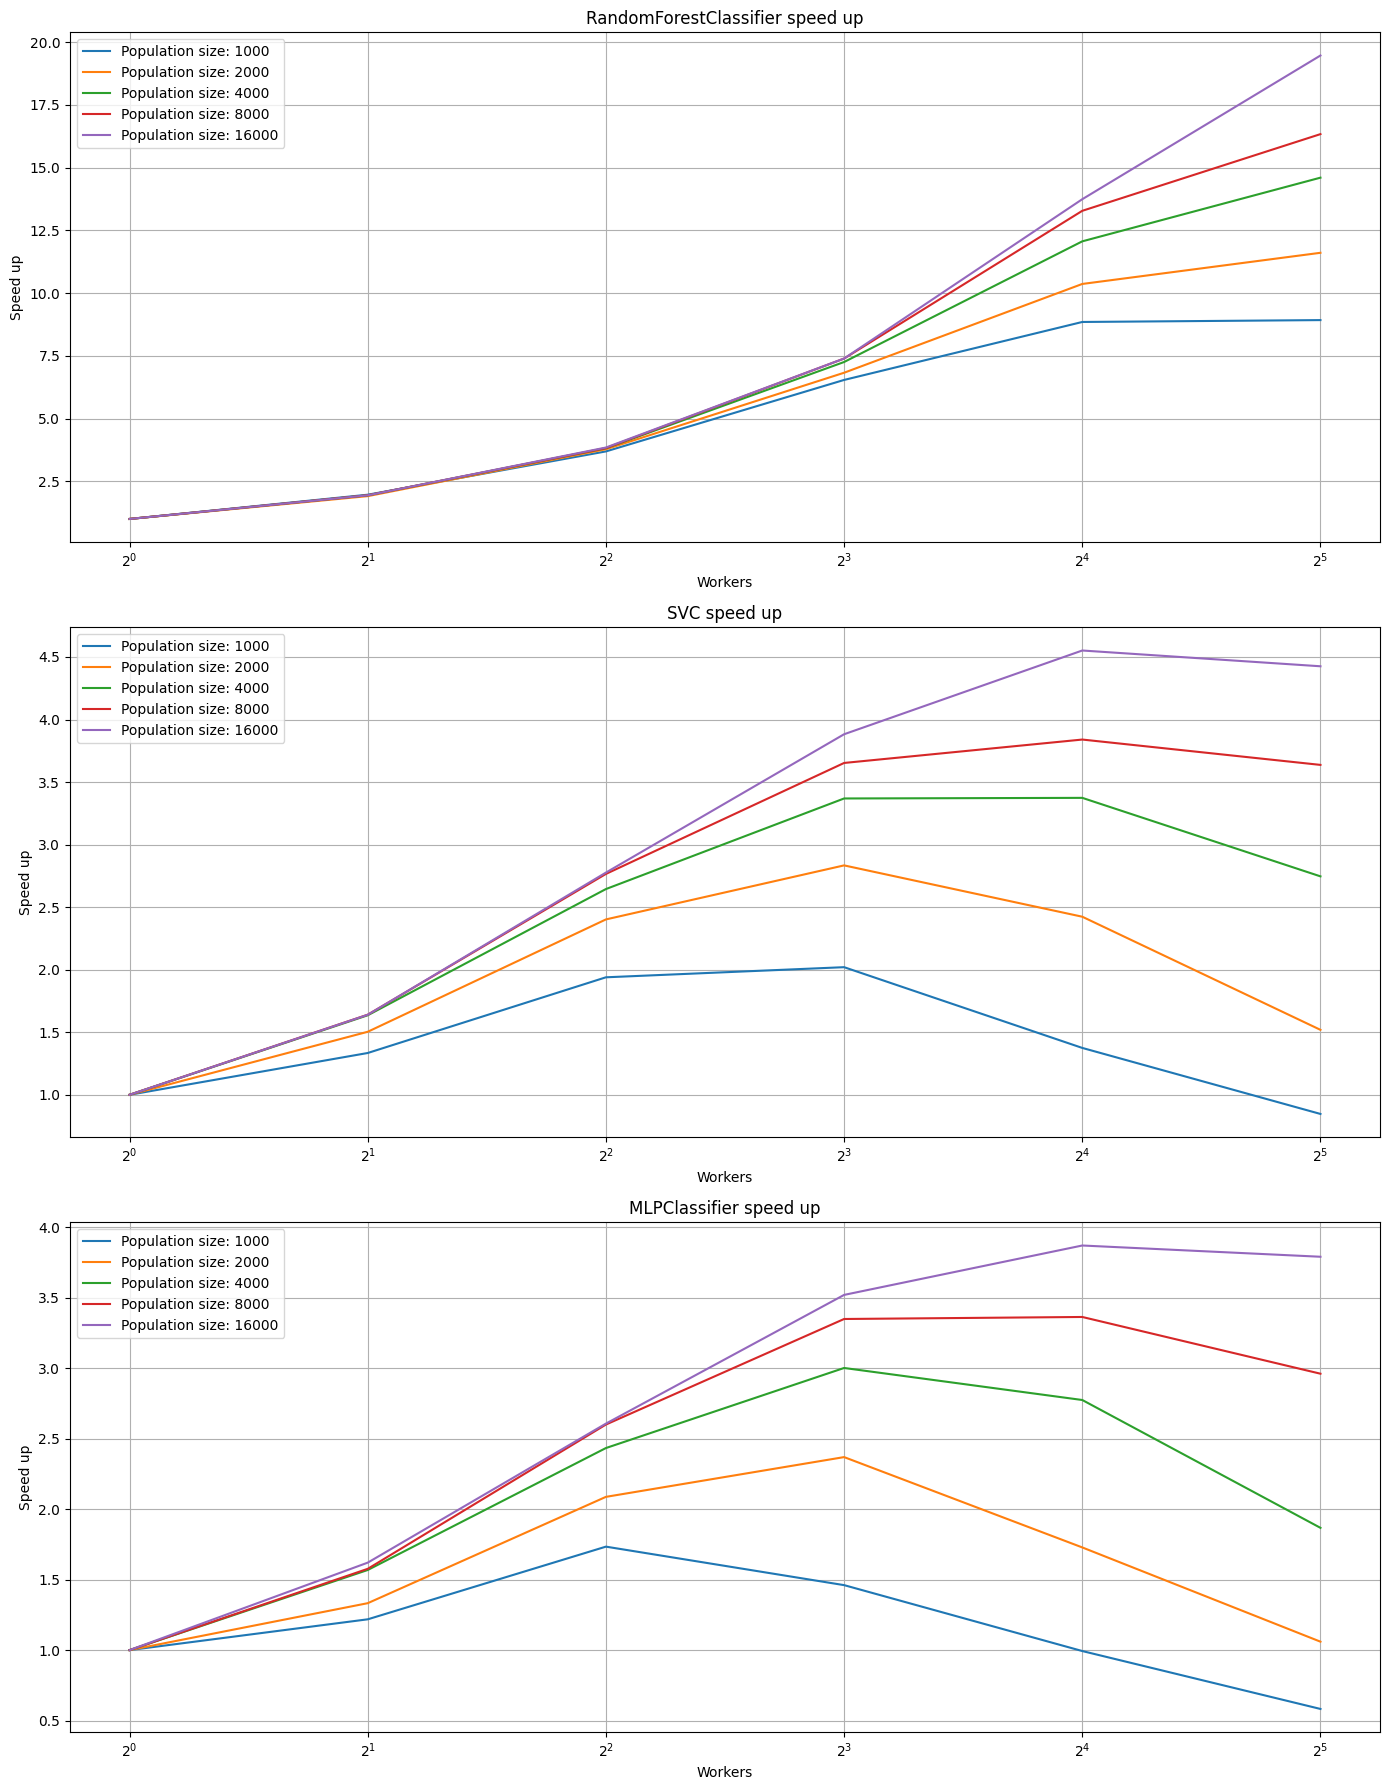

In [3]:
models = ppga_df["classifier"].unique()
workers = ppga_df["workers"].unique()
population_sizes = ppga_df["population_size"].unique()

fig, axes = plt.subplots(3, 1, figsize=(14, 18))


for model, ax in zip(models, axes):
    for ps in population_sizes:
        mask = (ppga_df["classifier"] == model) & (ppga_df["population_size"] == ps)
        ax.set_title(f"{model} speed up")
        ax.set_xlabel("Workers")
        ax.set_ylabel("Speed up")
        ax.plot(workers, ppga_df[mask]["speed_up"].values, label=f"Population size: {ps}")

        ax.set_xscale("log", base=2)
        ax.set_xticks(workers)
        ax.grid()
        ax.legend()

plt.tight_layout()
plt.show()

Come è facile notare, il Random Forest, che è anche il più lento, è quello che
trae più beneficio da una parallelizzazione più pesante. Gli altri modelli
sono molto più performanti in fase di predizione ed è quindi più difficile
ottenere un valore di speed up vicino al numero di worker utilizzati.

Nel problema di explainability in cui si richiedono numerose esecuzioni
dell'algoritmo genetico, si potrebbe pensare di partizionare il dataset in $m$
parti e adibire $n$ core a ciascuna partizione di modo da eseguire l'algoritmo
genetico parallelo su $n$ core e su $m$ punti contemporaneamente. Ovviamente
è necessaria un'analisi preliminare in cui si cerca di approssimare il numero 
di worker più adatto ad una singola esecuzione dell'algoritmo genetico. Il
numero di partizioni del dataset sarà semplicemente calcolato come:

$$\frac{ct}{w}$$

dove $ct$ è il numero di core totali presenti sulla macchina o che si intende
utilizzare e $w$ è il numero di worker stimato al passo precedente.

### Stabilità

Come ultima analisi vorrei valutare la stabilità delle performance
dell'algoritmo stesso andando a calcolare il coefficiente di variazione
del tempo impiegato. Andiamo quindi a calcolare

$$\frac{\sigma}{\mu}$$

dove $\mu$ e $\sigma$ sono media e deviazione standard dei tempi d'esecuzione
ottenuti da 10 prove ripetute dello stesso test.

In [4]:
ppga_df["var_coeff"] = ppga_df["time_std"] / ppga_df["time"]
ppga_df

,classifier,population_size,workers,time,time_std,speed_up,var_coeff
0,RandomForestClassifier,1000,1,16.299878,0.192166,1.000000,0.011789
1,RandomForestClassifier,1000,2,8.289707,0.097571,1.966279,0.011770
2,RandomForestClassifier,1000,4,4.415976,0.054106,3.691116,0.012252
3,RandomForestClassifier,1000,8,2.492459,0.055834,6.539677,0.022401
4,RandomForestClassifier,1000,16,1.841791,0.085909,8.850015,0.046644
...,...,...,...,...,...,...,...
85,MLPClassifier,16000,2,5.611317,0.031041,1.620846,0.005532
86,MLPClassifier,16000,4,3.487661,0.072067,2.607788,0.020663
87,MLPClassifier,16000,8,2.582851,0.143285,3.521334,0.055476
88,MLPClassifier,16000,16,2.348925,0.144400,3.872018,0.061475


In questo modo è possibile vedere la stabilità dell'algoritmo al variare di
parametri come numero di worker e dimensioni della popolazione. Come soglia
per separare i test più stabili dagli altri ho scelto un valore del 10% per
il coefficiente di variabilità.

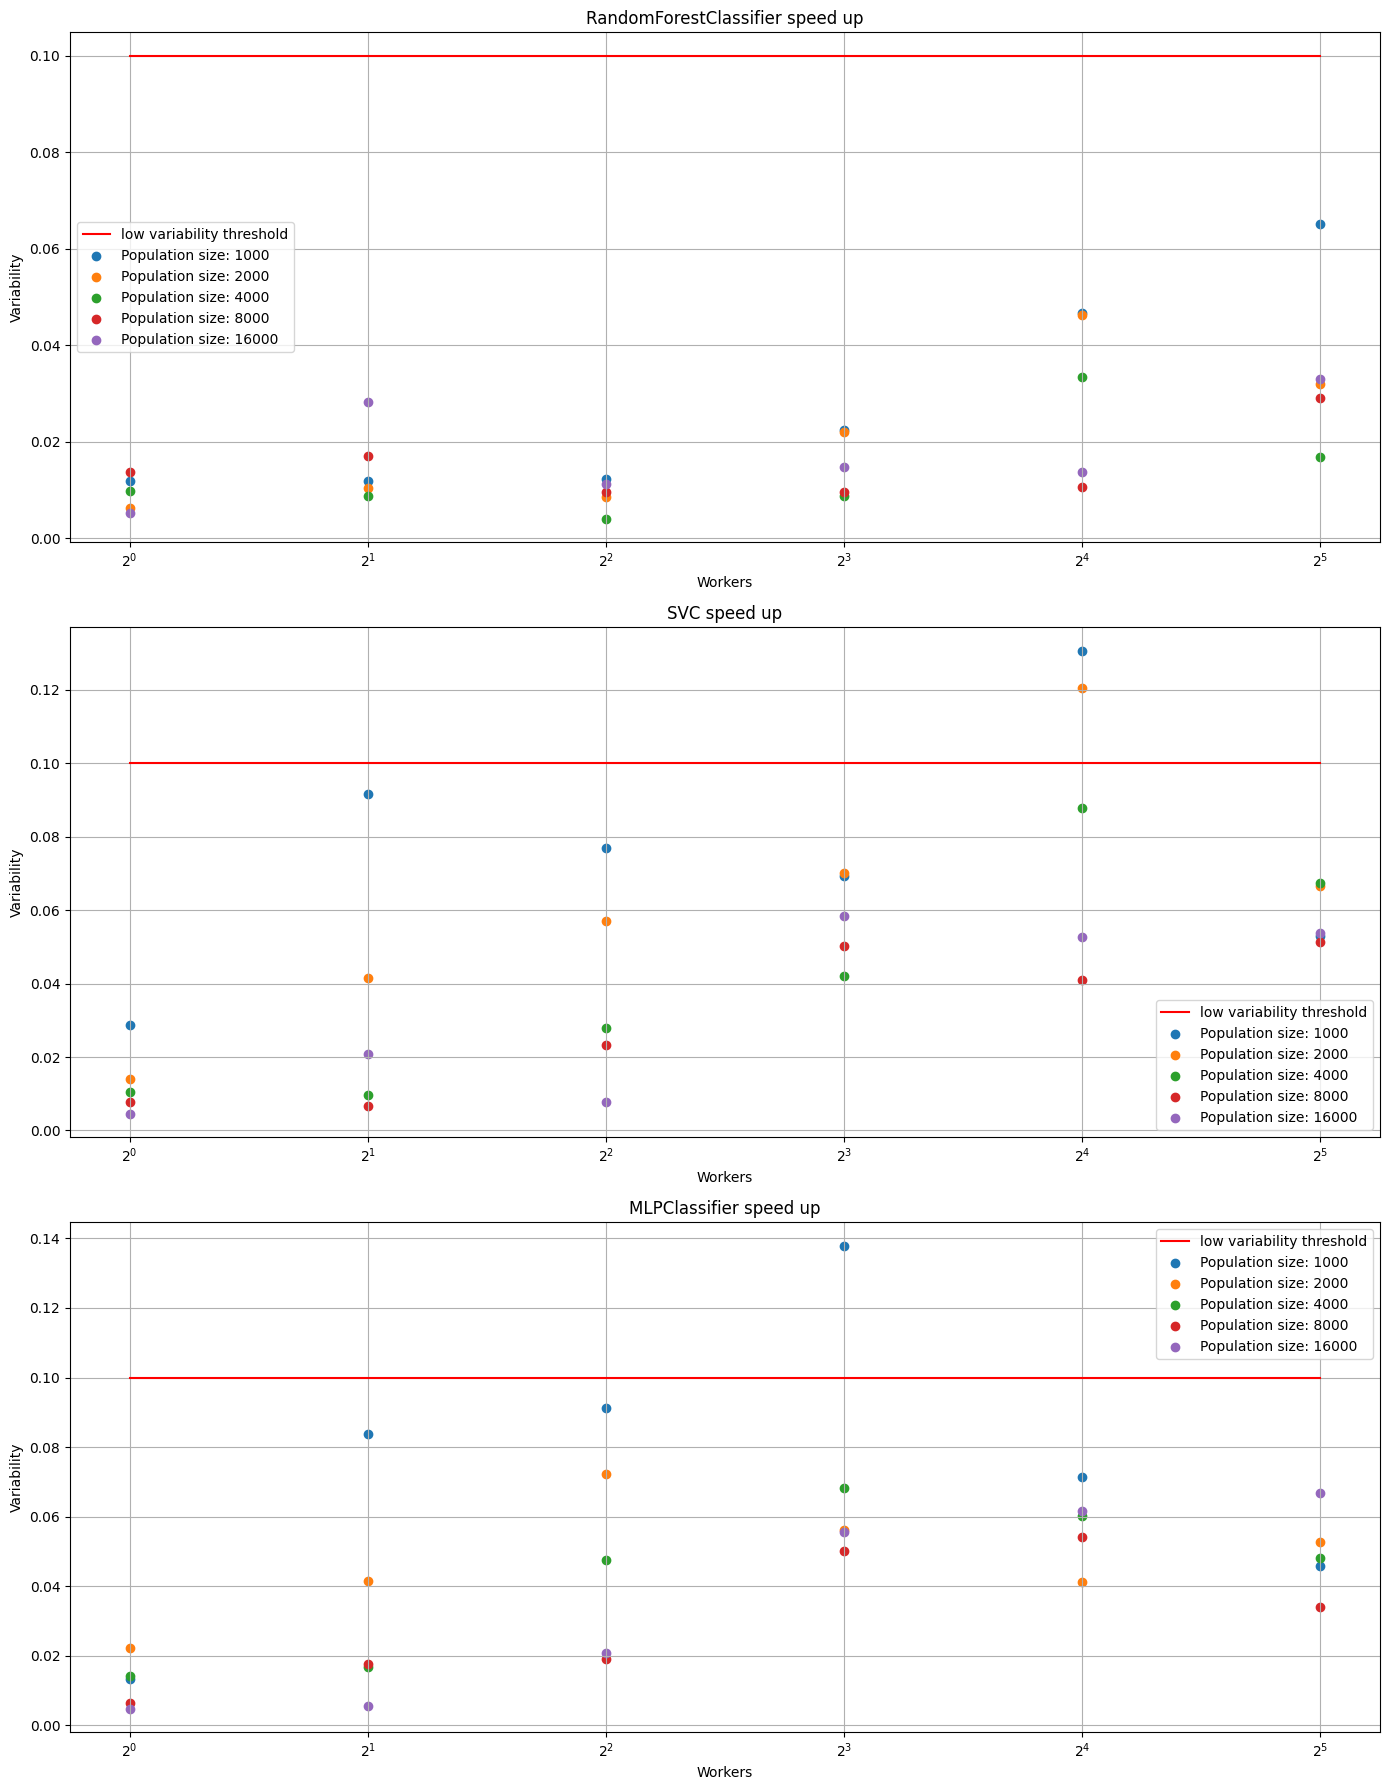

In [28]:
models = ppga_df["classifier"].unique()
workers = np.array(ppga_df["workers"].unique())
population_sizes = ppga_df["population_size"].unique()

fig, axes = plt.subplots(3, 1, figsize=(14, 18))


for model, ax in zip(models, axes):
    ax.plot([1, 32], [0.1, 0.1], c="r", label="low variability threshold")
    for ps in population_sizes:
        mask = (ppga_df["classifier"] == model) & (ppga_df["population_size"] == ps)
        ax.set_title(f"{model} speed up")
        ax.set_xlabel("Workers")
        ax.set_ylabel("Variability")
        ax.scatter(workers, ppga_df[mask]["var_coeff"].values, label=f"Population size: {ps}")

        ax.set_xscale("log", base=2)
        ax.set_xticks(workers)
        ax.grid()
        ax.legend()

plt.tight_layout()
plt.show()

In [6]:
deap_df = pd.read_csv("../datasets/deap_mp.csv")
deap_df

,classifier,population_size,workers,time,time_std
0,RandomForestClassifier,1000,1,21.416812,0.277863
1,RandomForestClassifier,1000,2,10.992114,0.072984
2,RandomForestClassifier,1000,4,5.685256,0.046589
3,RandomForestClassifier,1000,8,3.291673,0.101589
4,RandomForestClassifier,1000,16,1.907754,0.147648
...,...,...,...,...,...
85,MLPClassifier,16000,2,6.411653,0.055942
86,MLPClassifier,16000,4,3.867469,0.034954
87,MLPClassifier,16000,8,3.064032,0.103000
88,MLPClassifier,16000,16,2.066656,0.216749


In [7]:
reference_times = deap_df[deap_df['workers'] == 1].set_index(['classifier', 'population_size'])['time']

deap_df['speed_up'] = deap_df.apply(lambda row: reference_times.loc[(row['classifier'], row['population_size'])] / row['time'], axis=1)
deap_df

,classifier,population_size,workers,time,time_std,speed_up
0,RandomForestClassifier,1000,1,21.416812,0.277863,1.000000
1,RandomForestClassifier,1000,2,10.992114,0.072984,1.948380
2,RandomForestClassifier,1000,4,5.685256,0.046589,3.767080
3,RandomForestClassifier,1000,8,3.291673,0.101589,6.506360
4,RandomForestClassifier,1000,16,1.907754,0.147648,11.226189
...,...,...,...,...,...,...
85,MLPClassifier,16000,2,6.411653,0.055942,1.633733
86,MLPClassifier,16000,4,3.867469,0.034954,2.708472
87,MLPClassifier,16000,8,3.064032,0.103000,3.418675
88,MLPClassifier,16000,16,2.066656,0.216749,5.068540


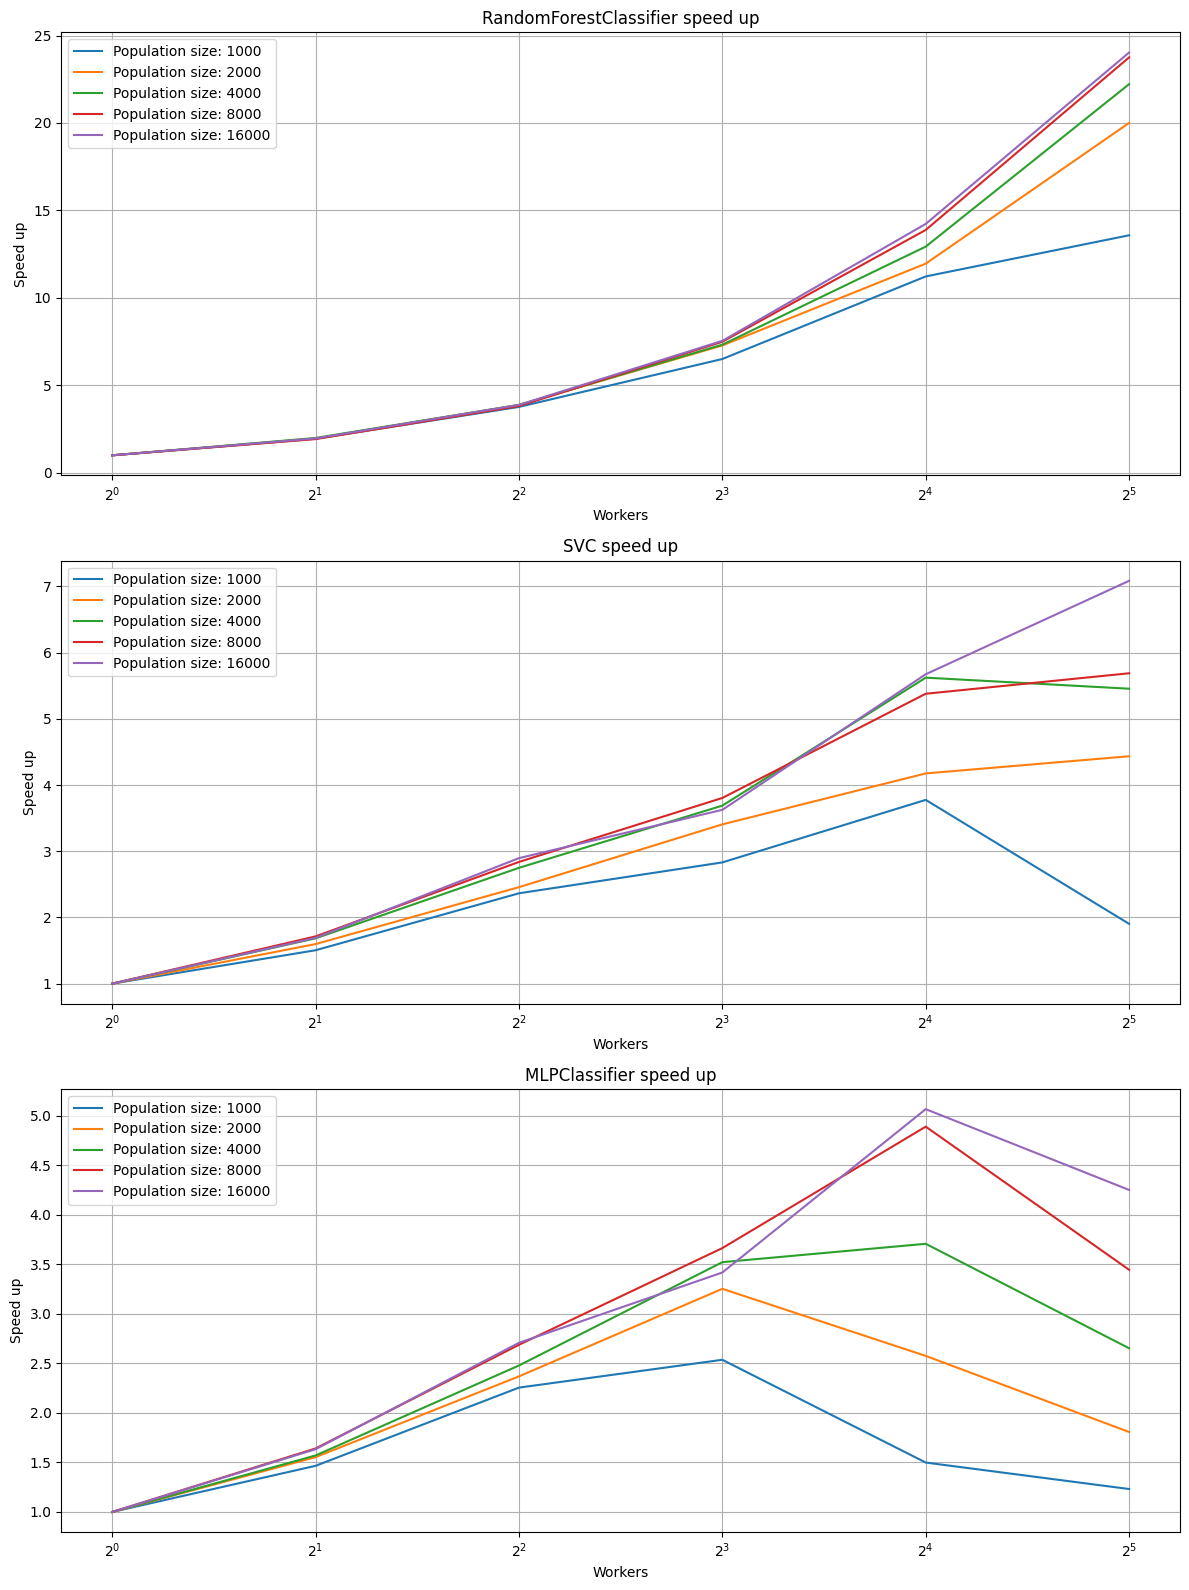

In [8]:
models = deap_df["classifier"].unique()
workers = deap_df["workers"].unique()
population_sizes = deap_df["population_size"].unique()

fig, axes = plt.subplots(3, 1, figsize=(12, 16))

for model, ax in zip(models, axes):
    for ps in population_sizes:
        mask = (deap_df["classifier"] == model) & (deap_df["population_size"] == ps)
        ax.set_title(f"{model} speed up")
        ax.set_xlabel("Workers")
        ax.set_ylabel("Speed up")
        ax.plot(workers, deap_df[mask]["speed_up"].values, label=f"Population size: {ps}")

        ax.set_xscale("log", base=2)
        ax.set_xticks(workers)
        ax.grid()
        ax.legend()

plt.tight_layout()
plt.show()

In [9]:
deap_df["var_coeff"] = deap_df["time_std"] / deap_df["time"]
deap_df

,classifier,population_size,workers,time,time_std,speed_up,var_coeff
0,RandomForestClassifier,1000,1,21.416812,0.277863,1.000000,0.012974
1,RandomForestClassifier,1000,2,10.992114,0.072984,1.948380,0.006640
2,RandomForestClassifier,1000,4,5.685256,0.046589,3.767080,0.008195
3,RandomForestClassifier,1000,8,3.291673,0.101589,6.506360,0.030863
4,RandomForestClassifier,1000,16,1.907754,0.147648,11.226189,0.077394
...,...,...,...,...,...,...,...
85,MLPClassifier,16000,2,6.411653,0.055942,1.633733,0.008725
86,MLPClassifier,16000,4,3.867469,0.034954,2.708472,0.009038
87,MLPClassifier,16000,8,3.064032,0.103000,3.418675,0.033616
88,MLPClassifier,16000,16,2.066656,0.216749,5.068540,0.104879


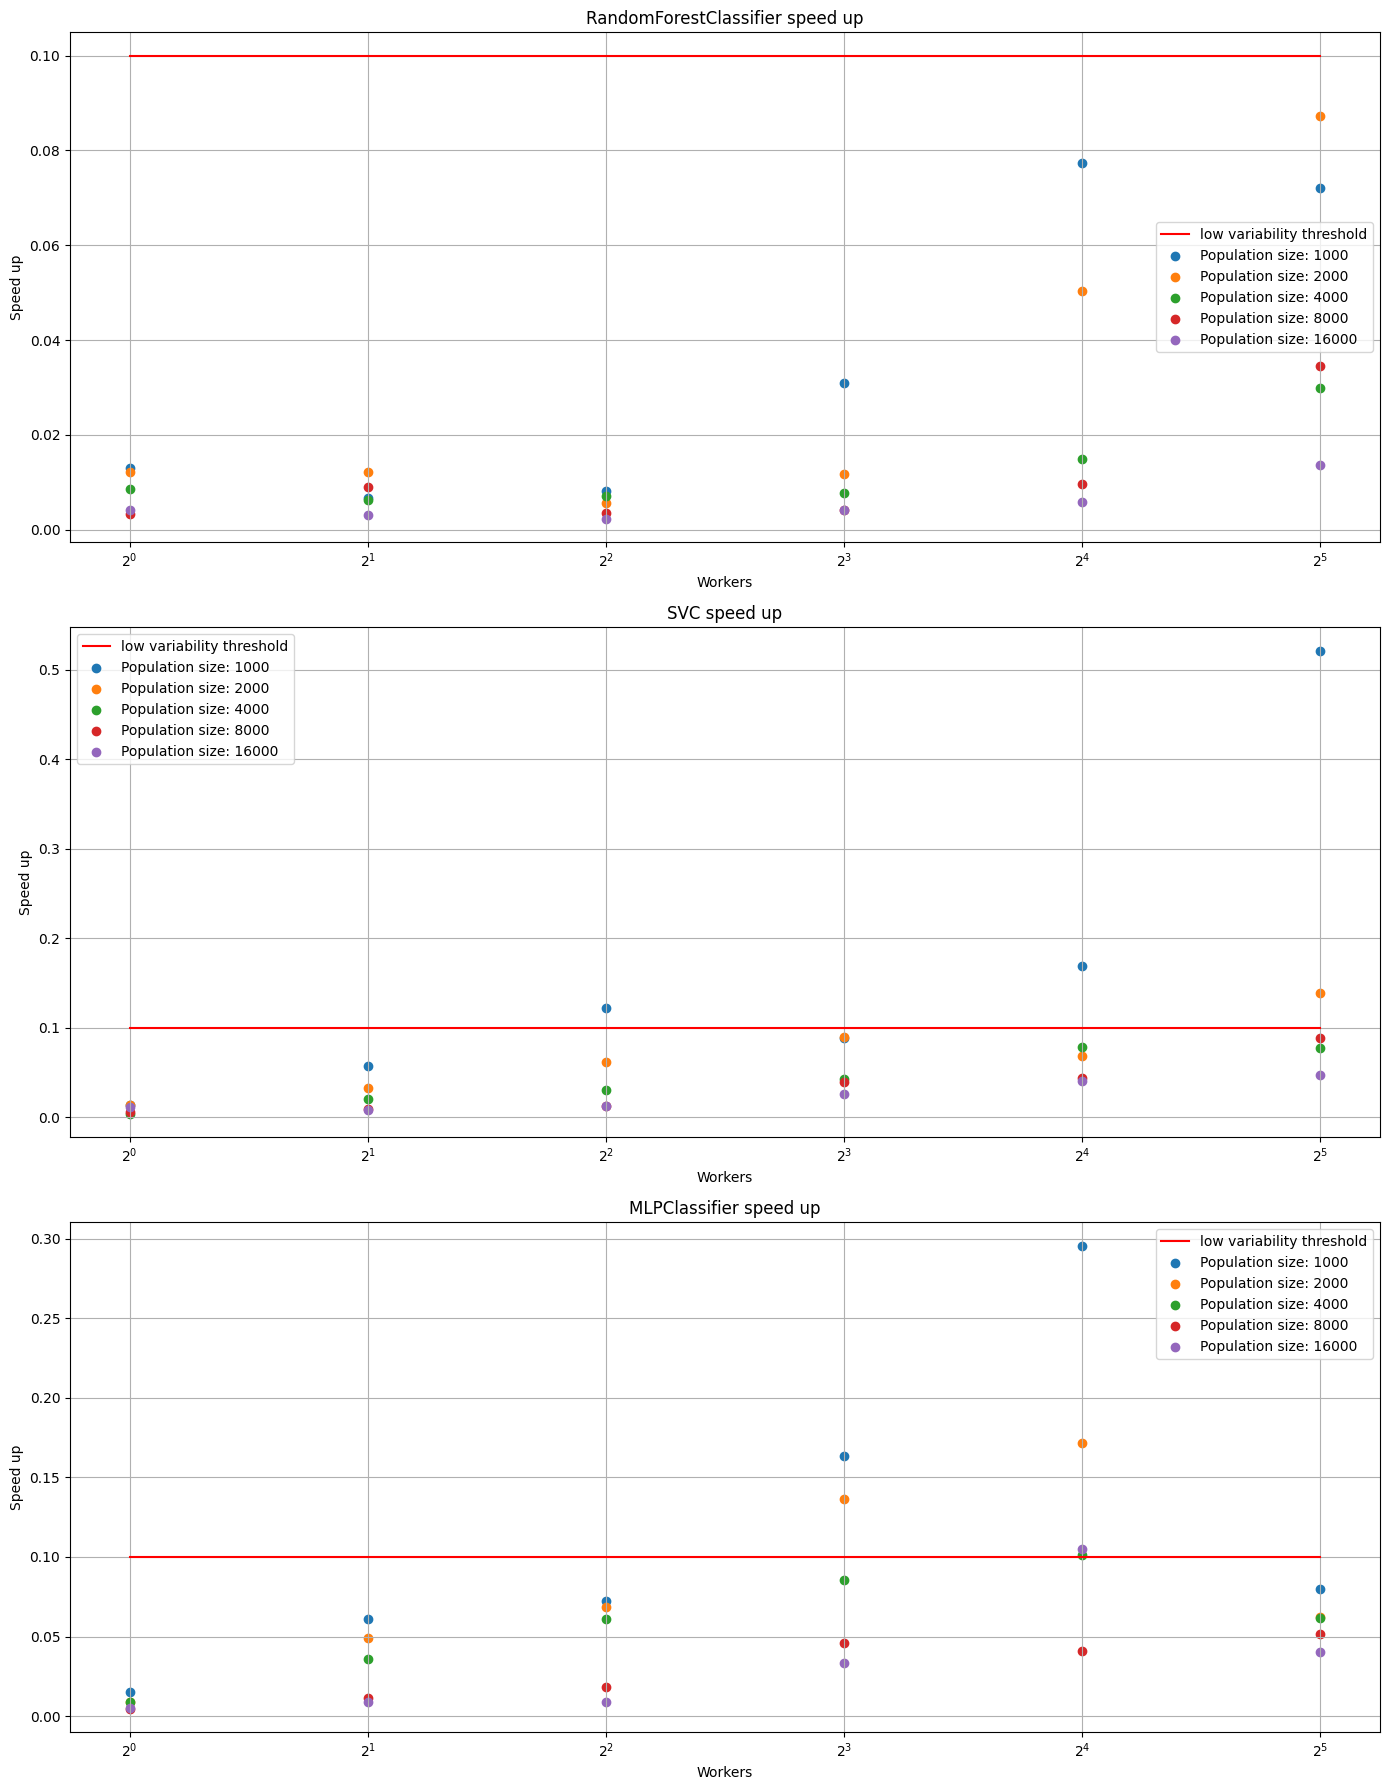

In [10]:
models = deap_df["classifier"].unique()
workers = deap_df["workers"].unique()
population_sizes = deap_df["population_size"].unique()

fig, axes = plt.subplots(3, 1, figsize=(14, 18))


for model, ax in zip(models, axes):
    ax.plot([1, 32], [0.1, 0.1], c="r", label="low variability threshold")
    for i, ps in enumerate(population_sizes):
        mask = (deap_df["classifier"] == model) & (deap_df["population_size"] == ps)
        ax.set_title(f"{model} speed up")
        ax.set_xlabel("Workers")
        ax.set_ylabel("Speed up")
        ax.scatter(workers, deap_df[mask]["var_coeff"].values, label=f"Population size: {ps}")

        ax.set_xscale("log", base=2)
        ax.set_xticks(workers)
        ax.grid()
        ax.legend()

plt.tight_layout()
plt.show()